# Compressed Representation
A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

Let's get started by importing our libraries and getting the dataset.



# imports and helpers

In [2]:
# ! pip install torch
# ! pip install torchvision
# ! pip inatall matplotlib

In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img, ax = None):
    #img = img / 2 + 0.5  # unnormalize
    is_tensor = isinstance(img, torch.Tensor)
    if is_tensor:
        img = img.detach().numpy()

    if ax:
        ax.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
        return
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']



# weights and bias

In [5]:
# import wandb
# #! wandb login
#
# # Initialize a new W&B run
# wandb.init()
# # 50187b18256c8d9e1e0a36d7254f0906c1ba315e

In [6]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


# Data setup



In [7]:
# Create training and test dataloaders

num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Visualize the data

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

hi


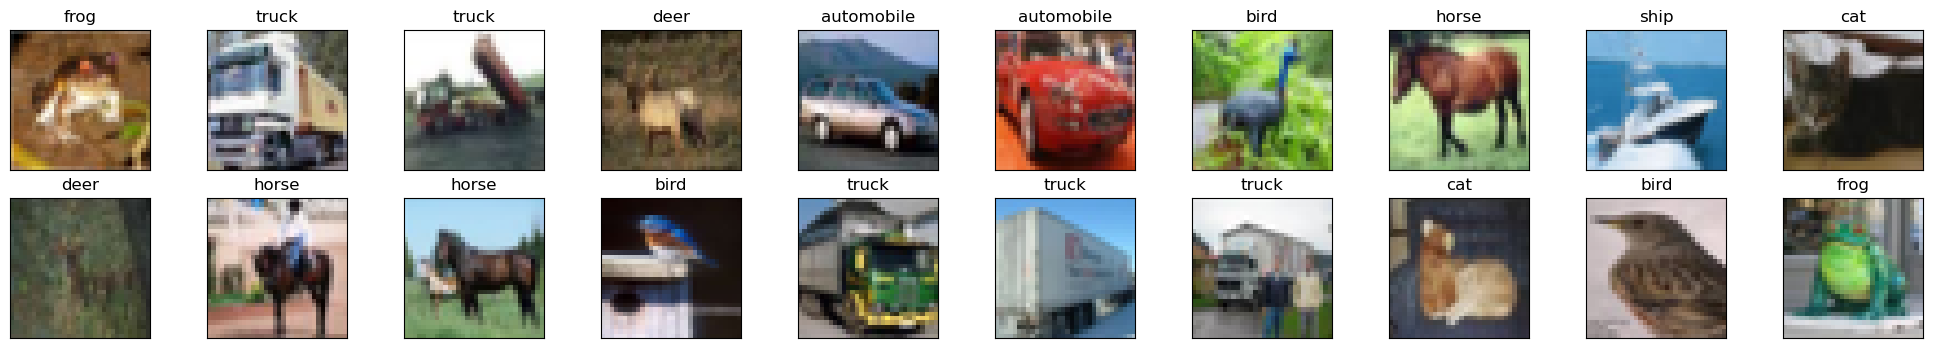

In [9]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
print("hi")
#
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# imshow(images[0])
# plt.show()

# Network architecture

## Convolutional Autoencoder

In [113]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv0 = nn.Conv2d(3, 16, 3, padding=1)
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(16, 8, 3, padding=1)
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv0 = nn.ConvTranspose2d(8, 8, 2, stride=2)

        self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        x = F.relu(self.conv0(x))
        x = self.pool(x)
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        x = F.relu(self.t_conv0(x))
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))


        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv0): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (t_conv1): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


## Fully Connected Autoencoder

In [114]:
class FCAutoEncoder(nn.Module):

    def __init__(self):
        super(FCAutoEncoder, self).__init__()

        #encoder
        self.e1 = nn.Linear(3*32*32,256)
        self.e2 = nn.Linear(256,128)

        #Latent View
        self.lv = nn.Linear(128,64)

        #Decoder
        self.d1 = nn.Linear(64,128)
        self.d2 = nn.Linear(128,256)

        self.output_layer = nn.Linear(256,3*32*32)

    def forward(self,x):
        x = x.view(-1, 3 * 32 ** 2)
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))

        x = torch.sigmoid(self.lv(x))

        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))


        x = F.sigmoid(self.output_layer(x))
        x = x.view(-1,3, 32, 32)

        return x

model2 = FCAutoEncoder()
model2.eval()

FCAutoEncoder(
  (e1): Linear(in_features=3072, out_features=256, bias=True)
  (e2): Linear(in_features=256, out_features=128, bias=True)
  (lv): Linear(in_features=128, out_features=64, bias=True)
  (d1): Linear(in_features=64, out_features=128, bias=True)
  (d2): Linear(in_features=128, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=3072, bias=True)
)


# Training
Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards.

We are not concerned with labels in this case, just images, which we can get from the train_loader. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use BCELoss. And compare output images and input images as follows:

## Loss function and optimizer

we will compute the loss as such:
loss = criterion(outputs, images)


In [15]:
# loss function
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# we will compute the loss as such
# loss = criterion(outputs, images)


# DataLoader

<class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

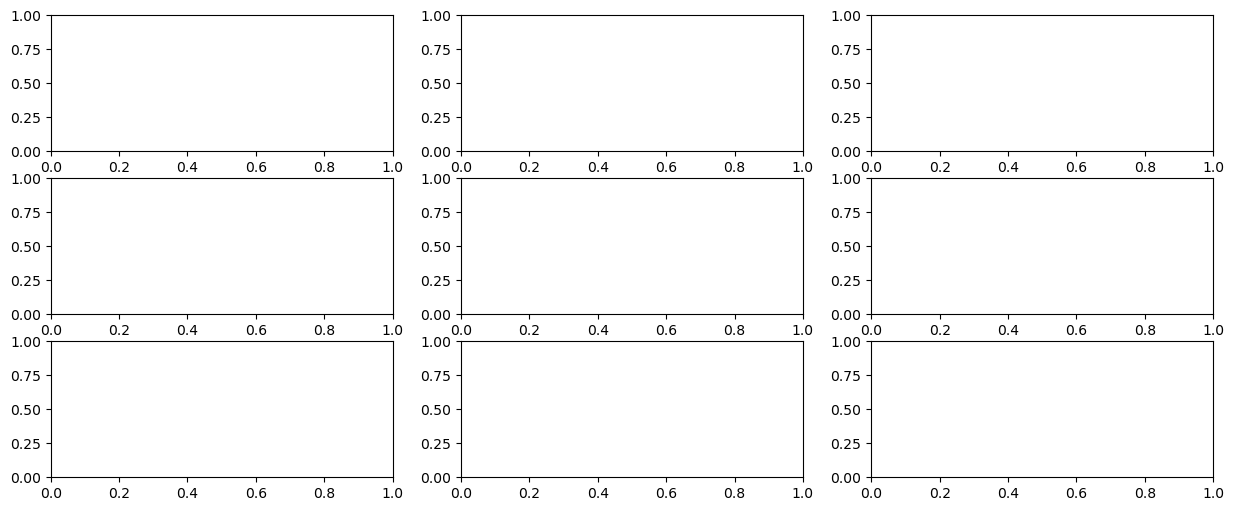

In [54]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
#
reconstructed_images = model(torch.from_numpy(images)).detach().numpy()
# plot the images in the batch, along with the corresponding labels
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(reconstructed_images[i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(reconstructed_images[i] - images[i], ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well


plt.tight_layout()
plt.show()

## Training loop

In [120]:
def train(model,
          criterion = nn.BCELoss(),
          n_epochs = 10,
          lr=0.001,
          train_loader=train_loader
          ):


    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # number of epochs to train the model

    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            # no need to flatten images
            images, _ = data
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch,
            train_loss
        ))
    return model,train_loss

Epoch: 1 	Training Loss: 11.540441
Epoch: 2 	Training Loss: 11.537003
Epoch: 3 	Training Loss: 11.534312
Epoch: 4 	Training Loss: 11.531996
Epoch: 5 	Training Loss: 11.529943
Epoch: 6 	Training Loss: 11.528135
Epoch: 7 	Training Loss: 11.526525
Epoch: 8 	Training Loss: 11.525089
Epoch: 9 	Training Loss: 11.523802
Epoch: 10 	Training Loss: 11.522619
Epoch: 11 	Training Loss: 11.521561
Epoch: 12 	Training Loss: 11.520596
Epoch: 13 	Training Loss: 11.519697
Epoch: 14 	Training Loss: 11.518835
Epoch: 15 	Training Loss: 11.518036
Epoch: 16 	Training Loss: 11.517262
Epoch: 17 	Training Loss: 11.516480
Epoch: 18 	Training Loss: 11.515714
Epoch: 19 	Training Loss: 11.514977
Epoch: 20 	Training Loss: 11.514259
Epoch: 21 	Training Loss: 11.513577
Epoch: 22 	Training Loss: 11.512879
Epoch: 23 	Training Loss: 11.512143
Epoch: 24 	Training Loss: 11.511425
Epoch: 25 	Training Loss: 11.510762
Epoch: 26 	Training Loss: 11.510118
Epoch: 27 	Training Loss: 11.509482
Epoch: 28 	Training Loss: 11.508857


KeyboardInterrupt: 

In [ ]:
model2 = ConvAutoencoder()

In [126]:


# loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
# number of epochs to train the model
n_epochs = 100

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data

        images = model(images) - images

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model2(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
    ))

Epoch: 1 	Training Loss: 0.312171
Epoch: 2 	Training Loss: 0.223286
Epoch: 3 	Training Loss: 0.217072
Epoch: 4 	Training Loss: 0.210726
Epoch: 5 	Training Loss: 0.207093
Epoch: 6 	Training Loss: 0.204895
Epoch: 7 	Training Loss: 0.203380
Epoch: 8 	Training Loss: 0.202342
Epoch: 9 	Training Loss: 0.201468
Epoch: 10 	Training Loss: 0.200710


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


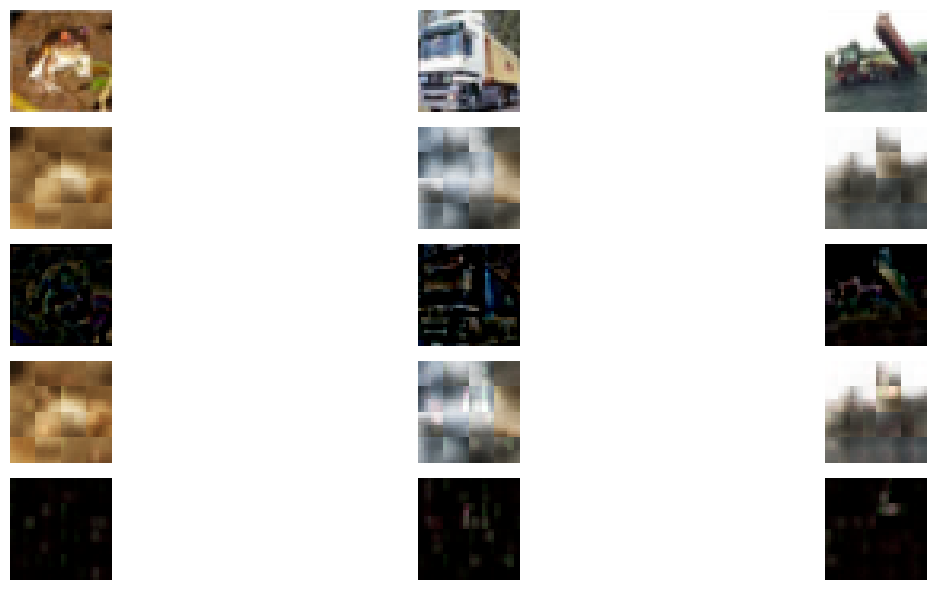

In [136]:
# # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display
#
reconstructed_images = model(torch.from_numpy(images))

residaual = torch.Tensor(reconstructed_images.detach().numpy() - images)

# plot the images in the batch, along with the corresponding labels
fig, axs = plt.subplots(5, 3, figsize=(15, 6))
# display 3 images
for i in range(3):
    # Displaying the original image
    imshow(images[i],ax=axs[0, i])
    axs[0, i].axis('off')  # Turn off the axis for a cleaner look

    # Displaying the reconstructed image
    imshow(reconstructed_images[i], ax=axs[1, i])
    axs[1, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(reconstructed_images[i].detach().numpy()- images[i], ax=axs[2, i])
    axs[2, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(model2(reconstructed_images[i]-torch.Tensor(images[i]))+reconstructed_images[i], ax=axs[3, i])
    axs[3, i].axis('off')  # Turn off the axis here as well

    # Displaying the reconstructed image
    imshow(model2(reconstructed_images[i]-torch.Tensor(images[i])), ax=axs[4, i])
    axs[4, i].axis('off')  # Turn off the axis here as well




plt.tight_layout()
plt.show()